### HW 2 ML in business Lukyanov Maksim

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

C:\Users\LMAXL\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LMAXL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [10]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [11]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [12]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [13]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\LMAXL\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 47.3 s


In [14]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 5min 7s


А теперь в 3 строчки обучим нашу модель

In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [16]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 9s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(7, 0.103757136), (17, 0.09010189), (20, 0.07837906), (23, 0.709)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: млрд граница рубль тысяча бюджет плата лекарство
topic_1: это человек год который ребёнок мочь свой
topic_2: напомнить солнце километр экономика прогноз снижение сигнал
topic_3: год который это мочь проект новый свой
topic_4: сотрудник эксперимент задержать полиция уголовный дело следствие
topic_5: год млн составить цена место показатель налог
topic_6: проверка температура площадь фронт день улица умереть
topic_7: восток фестиваль год препарат nn вода москва
topic_8: год который это россия российский рубль компания
topic_9: употребление автобус русь разделять проба заполнить сергеев
topic_10: золото вследствие женский лауреат билет золотой победитель
topic_11: превысить одежда автомобиль ухо надпись тепло новосибирский
topic_12: газ исследование сша научный технология американский запуск
topic_13: который год земля nn это также время
topic_14: смерть пенсия университет корпус виза сближение кремль
topic_15: выборы орган лодка государство власть кандидат преступник
topic_16: ра

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.035828,0.923258
1,4896,0.0,0.0,0.0,0.000000,0.0,0.0,0.098538,0.000000,0.0,...,0.0,0.453163,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.140944
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.103732,0.0,...,0.0,0.000000,0.090105,0.0,0.0,0.078363,0.0,0.000000,0.709038,0.000000
3,4898,0.0,0.0,0.0,0.244116,0.0,0.0,0.029525,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.225628,0.442320,0.048751
4,4899,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.243187,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.071931,0.141296


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.02102507, 0.318939  , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04747419, 0.08681569, 0.        ,
       0.        , 0.        , 0.        , 0.23026454, 0.        ,
       0.        , 0.        , 0.05759524, 0.        , 0.07217228,
       0.        , 0.        , 0.15537322, 0.        , 0.        ])

In [70]:
func_list = [np.mean, np.median, np.max]

In [84]:
#таблица ответов
compare_func_table = pd.DataFrame(columns=['function', 'roc_auc', 'precision', 'recall', 'f_score'])

In [85]:
#user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, 0)
    return user_vector

Загрузим нашу разметку

In [31]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [65]:
logreg = LogisticRegression()
#обучим 
#logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Рассчитаем Precision, Recall, F_score

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [88]:
def decision (func): # объединил весь процесс в одной функции
    
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, func), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

    X = pd.merge(user_embeddings, target, 'left')
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    #обучим 
    logreg.fit(X_train, y_train)
    
    preds = logreg.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                          title='Confusion matrix ' + func.__name__)
    plt.savefig("conf_matrix.png")
    plt.show()
    
    return {'function':func.__name__,
            'roc_auc':roc_auc_score(y_test, preds),
            'precision':precision[ix],
            'recall':recall[ix],
            'f_score':fscore[ix]
           } #append row to the dataframe 

Confusion matrix, without normalization
[[1612  143]
 [  60  185]]


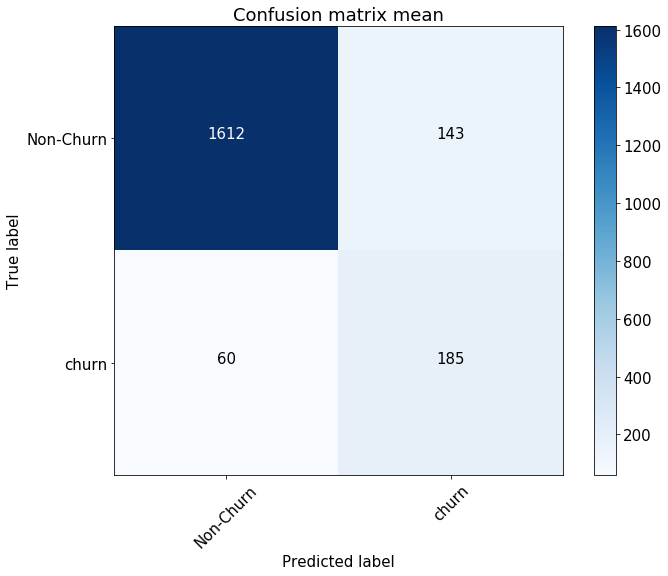

Confusion matrix, without normalization
[[1667   88]
 [  52  193]]


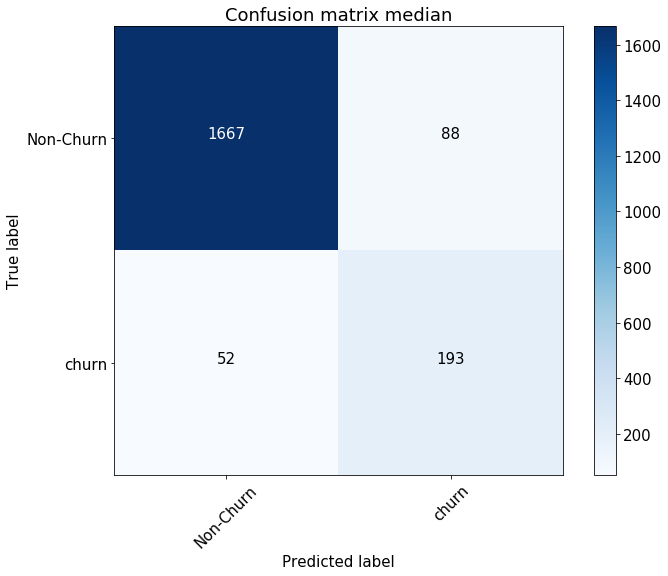

Confusion matrix, without normalization
[[1675   80]
 [  52  193]]


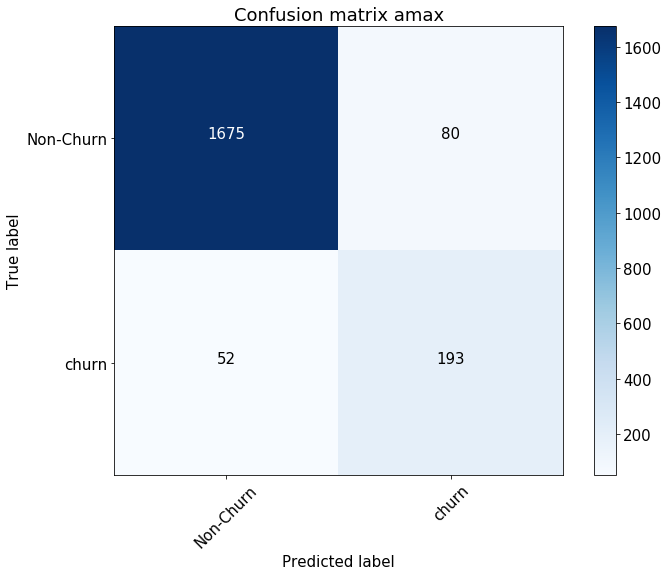

In [86]:
for func in func_list:
    compare_func_table = compare_func_table.append(decision(func), ignore_index=True)

In [87]:
compare_func_table

,function,roc_auc,precision,recall,f_score
0,mean,0.937871,0.565350,0.759184,0.648084
1,median,0.961851,0.687943,0.791837,0.736243
2,amax,0.966300,0.708029,0.791837,0.747592


6. Наилучшие результаты показал метод с использованием максимальных значений, второй по качеству - median.
Почему именно так - затрудняюсь ответить, т.к. не до конца пончл, что делает функция get_user_embedding